                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   24
Model:               SARIMAX(4, 0, 0)   Log Likelihood                -127.800
Date:                Sun, 21 May 2023   AIC                            267.601
Time:                        21:32:45   BIC                            274.669
Sample:                             0   HQIC                           269.476
                                 - 24                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    152.5148    112.481      1.356      0.175     -67.944     372.974
ar.L1          1.1551      0.237      4.883      0.000       0.691       1.619
ar.L2         -0.2509      0.266     -0.943      0.3

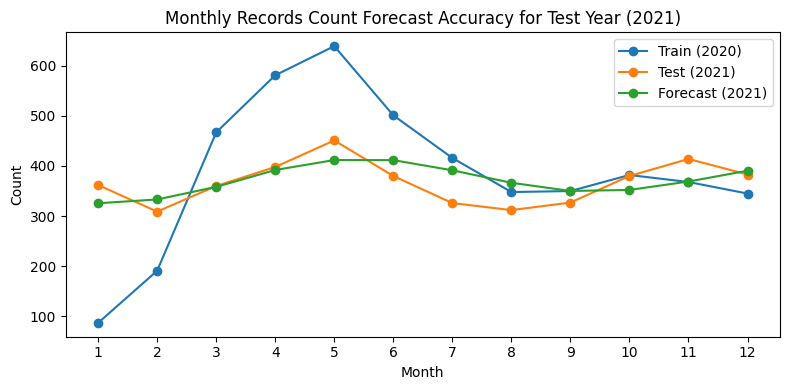

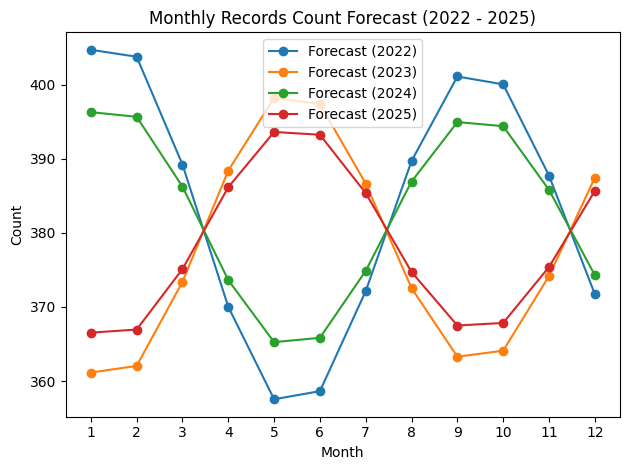

In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

df_data = pd.read_csv("gymdata-10000.csv")
df_data['Date'] = pd.to_datetime(df_data['Date'])

# Extract the year and month from the 'Date' column
df_data['Year'] = df_data['Date'].dt.year
df_data['Month'] = df_data['Date'].dt.month

# Group and count the records for each year and month
monthly_counts = df_data.groupby(['Year', 'Month']).size().reset_index(name='Count')

# Create the x-axis values
months = np.arange(1, 13)

# Get the latest year
latest_year = df_data['Year'].max()

# Filter the data for training and test based on the latest year
train_data = monthly_counts.loc[monthly_counts['Year'] < latest_year]['Count'].values
test_data = monthly_counts.loc[monthly_counts['Year'] == latest_year]['Count'].values

# Concatenate all years' data for overall count
all_years_data = monthly_counts['Count'].values

# Use auto_arima to determine the best ARIMA model
model = auto_arima(all_years_data, seasonal=False)

# Print the model summary
print(model.summary())

# Fit the ARIMA model using the training data
model_fit = ARIMA(train_data, order=model.order).fit()

# Get the forecasted values for the test period
forecast = model_fit.forecast(steps=len(test_data))

# Plot the data
plt.figure(figsize=(8, 4))
if len(np.unique(df_data['Year'])) - 1 > 1:
    train_label = f'Train ({df_data["Year"].min()} - {latest_year - 1})'
else:
    train_label = f'Train ({latest_year - 1})'
plt.plot(months, train_data, label=train_label, marker='o')
plt.plot(months, test_data, label=f'Test ({latest_year})', marker='o')
plt.plot(months, forecast, label=f'Forecast ({latest_year})', marker='o')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title(f'Monthly Records Count Forecast Accuracy for Test Year ({latest_year})')
plt.legend()
plt.xticks(months)
plt.tight_layout()
plt.show()

# Use the fitted model to predict the values for future years
forecast_years = range(latest_year, latest_year + 5)
combined_forecast = []

for i, year in enumerate(forecast_years):
    # Fit the model with the updated training data
    model_fit = ARIMA(train_data, order=model.order).fit()
    
    # Forecast for the current year
    forecast = model_fit.forecast(steps=12)
    combined_forecast.extend(forecast)

    if year != latest_year:  # Exclude the test data forecast year
        # Plot the forecasted values for the current year
        plt.plot(months, forecast, marker='o', label=f'Forecast ({year})')

    # Update the training data with the forecasted values
    train_data = np.concatenate([train_data, forecast])

# Generate the x-axis values for the combined forecast
combined_months = np.tile(months, len(forecast_years))

# Plot settings
plt.xlabel('Month')
plt.ylabel('Count')
plt.title(f'Monthly Records Count Forecast ({latest_year + 1} - {latest_year + 4})')
plt.xticks(months)
plt.legend()
plt.tight_layout()
plt.show()

In [142]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate MAE
mae = mean_absolute_error(test_data, forecast)
mae

31.336751897280866

In [143]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data, forecast))
rmse

38.68491059453669

In [144]:
# Calculate MAPE
mape = np.mean(np.abs((test_data - forecast) / test_data)) * 100
mape

8.941302012545274